## Evaluating FastPitch + pretrained HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model pre-trained on English.

In [1]:
import json
import nemo
import torch
import librosa
import numpy as np
import random

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
import IPython.display as ipd
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

[NeMo W 2023-09-10 10:02:52 optimizers:66] Could not import distributed_fused_adam optimizer from Apex
[NeMo W 2023-09-10 10:02:53 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-10 10:02:53 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-10 10:02:53 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-10 10:02:53 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-10

In [ ]:
###############################AUDIOS EVALUACIÓN PERCEPTAL################################
##Test Frase 1
test= "Miss Robert, las zapatillas color: blanco, talla: 11, referencia: 501-97-52, precio: 319 francos, se le entregarán en 1 semana."
##Frase 2
# test= "Sr. Johnson, el televisor multiestándar con mando a distancia, pantalla de 36 cm, referencia: 811-61-32, precio: 2 492 francos, le será entregado en 3 semanas."
##Frase 3
# test= "Sr. Moore, el taladro eléctrico D162, potencia: 550 vatios, 2 velocidades, referencia: 481-20-30, precio: 499 francos, se le entregará en 2 semanas."
##Frase 4
# test="El tren número 9783 procedente de Glasgow llegará a las 9:24, andén número 3, vía 'G'."
##Frase 5
# test="El tren número 7826 a Ipswich saldrá a las 12:20, andén número 9, vía 'A'."
##Frase 6
# test="El tren número 4320 procedente de Birmingham llegará a las 5:44, andén 2, vía C."
##########################################################################################

In [3]:
# test = "¡Ah! ¿No son franceses aquellos que corren hacia la calle de la Palma? Sí: ¿no ve Vd. los sombreros de piel? -Vamos allá. ¡Qué algazara!"
# test_id = "19demarzo_3135" # identifier for the audio corresponding to the test text
# data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/" # path to dataset folder with wav files from original dataset 
# test="¡Miedo! ¡Que yo tengo miedo! -exclamó el mancebo con un repentino arrebato que le puso encendido como la grana-. ¿A dónde vas,"
data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/"
test_id = "19demarzo_3270" 


In [4]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test, speaker=None):
    seed = random.randint(100000, 999999)
#   print(seed)
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        if speaker == None:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        else:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [5]:
# Muestra modelos almacenados tras el entranamiento, en los diferentes checkpoints, indicando
# la val_loss que forma parte del nombre.
import glob, os
lista = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28*/checkpoints/*.ckpt")
for le in sorted(lista, key=os.path.basename):
#   print(os.path.dirname(le),"\n\t",os.path.basename(le))
    print(os.path.dirname(le),"\n\t",os.path.basename(le))
print(sorted(lista, key=os.path.basename)[0])

/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints 
	 FastPitch--val_loss=0.7140-epoch=265.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints 
	 FastPitch--val_loss=0.7143-epoch=165.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints 
	 FastPitch--val_loss=0.7144-epoch=276.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints 
	 FastPitch--val_loss=0.7234-epoch=285-last.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_10-53-19/checkpoints 
	 FastPitch--val_loss=0.7326-epoch=100.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_10-53-19/checkpoints 
	 FastPitch--val_loss=0.7372-epoch=98.ckpt
/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_10-53-19/checkpoints 
	 FastPitch--val_loss=0.7414-epoch=87.ckpt
/home/irene/datas

In [6]:
# FastPitchModel.list_available_models()
# Load pretrained FastPitch models
# For English and Spanish (multispeaker requires fixing speaker id)
spec_gen_model_p = FastPitchModel.from_pretrained("tts_en_fastpitch")
spec_gen_model_es = FastPitchModel.from_pretrained("tts_es_fastpitch_multispeaker")

[NeMo I 2023-09-10 10:02:53 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2023-09-10 10:02:53 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2023-09-10 10:02:53 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-09-10 10:03:14 fastpitch:232] This checkpoint support will be dropped after NeMo 1.18.0.
[NeMo W 2023-09-10 10:03:14 experimental:27] Module <class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-09-10 10:03:14 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-09-10 10:03:14 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
  

[NeMo I 2023-09-10 10:03:14 features:291] PADDING: 1
[NeMo I 2023-09-10 10:03:15 save_restore_connector:249] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2023-09-10 10:03:15 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_es_fastpitch_multispeaker/6e511e09bdeff9aaf27368e0e12a82ea/tts_es_fastpitch_multispeaker.nemo.
[NeMo I 2023-09-10 10:03:15 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_es_fastpitch_multispeaker/6e511e09bdeff9aaf27368e0e12a82ea/tts_es_fastpitch_multispeaker.nemo
[NeMo I 2023-09-10 10:03:15 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-09-10 10:03:15 fastpitch:232] This checkpoint support will be dropped after NeMo 1.18.0.
[NeMo W 2023-09-10 10:03:16 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-09-10 10:03:16 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /home/rlangman/Data/openslr/spanish/ipa/train_fastpitch_manifest.json
      sample_rate: 44100
      sup_data_path: /home/rlangman/Data/openslr/spanish/ipa/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      - speaker_id
      n_fft

[NeMo I 2023-09-10 10:03:16 features:291] PADDING: 1
[NeMo I 2023-09-10 10:03:17 save_restore_connector:249] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_es_fastpitch_multispeaker/6e511e09bdeff9aaf27368e0e12a82ea/tts_es_fastpitch_multispeaker.nemo.


In [7]:
# load best fastpich model
import glob, os
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints/FastPitch--val_loss=0.7140-epoch=265.ckpt")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[0] # path_to_fastpitch_nemo_or_ckpt
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(fastpitch_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(fastpitch_model_path))

if ".nemo" in fastpitch_model_path:
    spec_gen_model_1 = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model_1 = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  FastPitch--val_loss=0.7140-epoch=265.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints


[NeMo W 2023-09-10 10:03:54 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 126.73465728759766
      pitch_std: 38.099849700927734
    dataloader_params:
      drop_last: false
   

[NeMo I 2023-09-10 10:03:54 features:291] PADDING: 1


In [8]:
# Load pretrained HifiGAN
hfg_pre_ngc = "tts_en_lj_hifigan_ft_mixerttsx" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_lj_hifigan
vocoder_model_p = HifiGanModel.from_pretrained(hfg_pre_ngc, strict=False).eval().cuda()

[NeMo I 2023-09-10 10:03:55 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.
[NeMo I 2023-09-10 10:03:55 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo
[NeMo I 2023-09-10 10:03:55 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-09-10 10:03:57 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_train.json
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 1
    
[NeMo W 2023-09-10 10:03:57 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_val.json
      min_duration: 3
      n_segments: 66048
    dataloader_params:
      drop_last: false


[NeMo I 2023-09-10 10:03:57 features:291] PADDING: 0
[NeMo I 2023-09-10 10:03:57 features:299] STFT using exact pad
[NeMo I 2023-09-10 10:03:57 features:291] PADDING: 0
[NeMo I 2023-09-10 10:03:57 features:299] STFT using exact pad
[NeMo I 2023-09-10 10:03:58 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.


In [9]:
# Load finetune retrained HifiGAN
import glob, os
#Modelo 1 HifIGAN
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_15-53-01/checkpoints/HifiGan--val_loss=0.5618-epoch=0.ckpt")
hifigan_model_path = sorted(file_list, key=os.path.basename)[0]
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(hifigan_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(hifigan_model_path))
vocoder_model_1 = HifiGanModel.load_from_checkpoint(checkpoint_path=hifigan_model_path).eval().cuda()

#Modelo 2 HifIGAN
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_16-04-11/checkpoints/HifiGan--val_loss=0.9747-epoch=0.ckpt")
hifigan_model_path = sorted(file_list, key=os.path.basename)[0]
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(hifigan_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(hifigan_model_path))
vocoder_model_2 = HifiGanModel.load_from_checkpoint(checkpoint_path=hifigan_model_path).eval().cuda()

#Modelo 3 HifIGAN
file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_18-20-28/checkpoints/HifiGan--val_loss=0.9774-epoch=1.ckpt")
hifigan_model_path = sorted(file_list, key=os.path.basename)[0]
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(hifigan_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(hifigan_model_path))
vocoder_model_3 = HifiGanModel.load_from_checkpoint(checkpoint_path=hifigan_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  HifiGan--val_loss=0.5618-epoch=0.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_15-53-01/checkpoints


[NeMo W 2023-09-10 10:04:05 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: train_manifest_text_normed_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2023-09-10 10:04:05 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.Vo

[NeMo I 2023-09-10 10:04:05 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:05 features:299] STFT using exact pad
[NeMo I 2023-09-10 10:04:05 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:05 features:299] STFT using exact pad
# CARGAREMOS EL MODELO ....... :  HifiGan--val_loss=0.9747-epoch=0.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_16-04-11/checkpoints


[NeMo W 2023-09-10 10:04:14 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: train_manifest_text_normed_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2023-09-10 10:04:14 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.Vo

[NeMo I 2023-09-10 10:04:14 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:14 features:299] STFT using exact pad
[NeMo I 2023-09-10 10:04:14 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:14 features:299] STFT using exact pad
# CARGAREMOS EL MODELO ....... :  HifiGan--val_loss=0.9774-epoch=1.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-11_18-20-28/checkpoints


[NeMo W 2023-09-10 10:04:23 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: train_manifest_text_normed_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2023-09-10 10:04:23 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.Vo

[NeMo I 2023-09-10 10:04:23 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:23 features:299] STFT using exact pad
[NeMo I 2023-09-10 10:04:23 features:291] PADDING: 0
[NeMo I 2023-09-10 10:04:23 features:299] STFT using exact pad


original audio


torch.Size([1, 80, 628])
torch.Size([1, 80, 628])


[NeMo W 2023-09-10 10:10:16 fastpitch:286] parse() is meant to be called in eval mode.


torch.Size([1, 80, 628])


[NeMo W 2023-09-10 10:10:16 tts_tokenizers:477] Text: [¡miedo! ¡KYUW1 YOW1 tengo miedo! -exclamo EH1L MAA0NCHEH1BOW0 KAA1N un repentino arrebato KYUW1 LAH0 puso encendido KOW1MOW0 la GRAE1NAH0-. ¿a DAA1ND vas,] contains unknown char/phoneme: [¡].Original text: [¡Miedo! ¡Que yo tengo miedo! -exclamo el mancebo con un repentino arrebato que le puso encendido como la grana-. ¿A donde vas,]. Symbol will be skipped.
[NeMo W 2023-09-10 10:10:16 tts_tokenizers:477] Text: [¡miedo! ¡KYUW1 YOW1 tengo miedo! -exclamo EH1L MAA0NCHEH1BOW0 KAA1N un repentino arrebato KYUW1 LAH0 puso encendido KOW1MOW0 la GRAE1NAH0-. ¿a DAA1ND vas,] contains unknown char/phoneme: [¡].Original text: [¡Miedo! ¡Que yo tengo miedo! -exclamo el mancebo con un repentino arrebato que le puso encendido como la grana-. ¿A donde vas,]. Symbol will be skipped.
[NeMo W 2023-09-10 10:10:16 tts_tokenizers:477] Text: [¡miedo! ¡KYUW1 YOW1 tengo miedo! -exclamo EH1L MAA0NCHEH1BOW0 KAA1N un repentino arrebato KYUW1 LAH0 puso encendido

torch.Size([1, 80, 864])


[NeMo W 2023-09-10 10:10:17 fastpitch:286] parse() is meant to be called in eval mode.
[NeMo W 2023-09-10 10:10:17 fastpitch:363] generate_spectrogram() is meant to be called in eval mode.


torch.Size([1, 80, 547])
torch.Size([1, 80, 628])


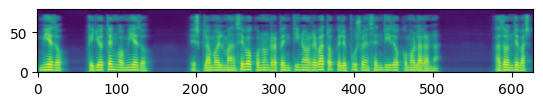

Modelo 1 Finetuned HiFiGAN


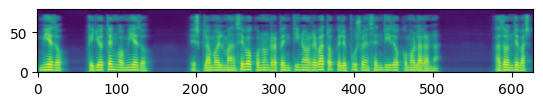

Modelo 2 Finetuned HiFiGAN


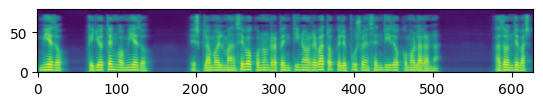

Modelo 3 Finetuned HiFiGAN


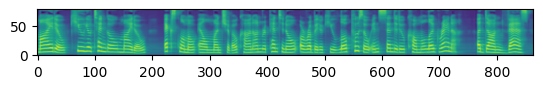

Pretrained EN model [tts_en_fastpitch]:


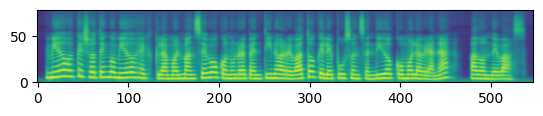

Pretrained ES_MULTISPEAKER model [tts_es_fastpitch_multispeaker]:


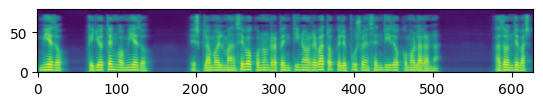

Trained (CSS10) Best val_loss


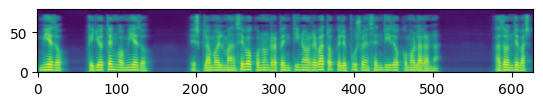

Trained (CSS10) Best val_loss with Finetune HifiGAN (V0)


In [15]:
%matplotlib inline

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))

audio_1, spectrogram_1 = evaluate_spec_fastpitch_ckpt(spec_gen_model_1, vocoder_model_1, test)
audio_2, spectrogram_2 = evaluate_spec_fastpitch_ckpt(spec_gen_model_1, vocoder_model_2, test)
audio_3, spectrogram_3 = evaluate_spec_fastpitch_ckpt(spec_gen_model_1, vocoder_model_3, test)

audio_p, spectrogram_p = evaluate_spec_fastpitch_ckpt(spec_gen_model_p, vocoder_model_p, test)
audio_e, spectrogram_e = evaluate_spec_fastpitch_ckpt(spec_gen_model_es, vocoder_model_p, test, speaker=1)
audio_1_1, spectrogram_1_1 = evaluate_spec_fastpitch_ckpt(spec_gen_model_1, vocoder_model_p, test)


# visualize the spectrogram

# visualize the spectrogram
if spectrogram_1 is not None:
    imshow(spectrogram_1, origin="lower")
    plt.show()
print("Modelo 1 Finetuned HiFiGAN")
ipd.display(ipd.Audio(audio_1, rate=22050))

# visualize the spectrogram
if spectrogram_2 is not None:
    imshow(spectrogram_2, origin="lower")
    plt.show()
print("Modelo 2 Finetuned HiFiGAN")
ipd.display(ipd.Audio(audio_2, rate=22050))

# visualize the spectrogram
if spectrogram_3 is not None:
    imshow(spectrogram_3, origin="lower")
    plt.show()
print("Modelo 3 Finetuned HiFiGAN")
ipd.display(ipd.Audio(audio_3, rate=22050))

if spectrogram_p is not None:
    imshow(spectrogram_p, origin="lower")
    plt.show()
print("Pretrained EN model [tts_en_fastpitch]:")
ipd.display(ipd.Audio(audio_p, rate=22050))

# visualize the spectrogram
if spectrogram_e is not None:
    imshow(spectrogram_e, origin="lower")
    plt.show()
print("Pretrained ES_MULTISPEAKER model [tts_es_fastpitch_multispeaker]:")
ipd.display(ipd.Audio(audio_e, rate=22050))

# visualize the spectrogram
if spectrogram_1 is not None:
    imshow(spectrogram_1, origin="lower")
    plt.show()
print("Trained (CSS10) Best val_loss")
ipd.display(ipd.Audio(audio_1, rate=22050))

# visualize the spectrogram
if spectrogram_1_1 is not None:
    imshow(spectrogram_1_1, origin="lower")
    plt.show()
print("Trained (CSS10) Best val_loss with Finetune HifiGAN (V0)")
ipd.display(ipd.Audio(audio_1_1, rate=22050))

In [11]:
import librosa
import soundfile as sf

In [12]:
!mkdir muestrasModelosFinetunedHifiGAN

In [13]:
# data, samplerate = sf.read('audio_finetuned.wav')
sf.write('muestrasModelosFinetunedHifiGAN/audio_modelo_Finetuned_HifiGAN_1.wav', audio_1, 22050)
sf.write('muestrasModelosFinetunedHifiGAN/audio_modelo_Finetuned_HifiGAN_2.wav', audio_2, 22050)
sf.write('muestrasEvaluaciónPerceptal/audio_modelo_Finetuned_HifiGAN_3.wav', audio_3, 22050)

In [14]:
audio = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/19demarzo_3270.wav" # path to dataset folder with wav files from original dataset

# Save the first audio file (replace 'output_audio1.wav' with your desired output file name)
data, samplerate = sf.read(audio)
sf.write('muestrasModelosBase/audioOrigBase.wav', data, samplerate)

# Save the second audio file (replace 'output_audio2.wav' with your desired output file name)